In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

import pandas as pd
from pathlib import Path
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib as mpl
from scipy import stats

import re

In [2]:
def get_intron_size(starts, ends, strand):
        intron_len = 0
        if len(ends) == 1:
            end = int(ends[0])
            if strand == "+":
                return end - start
            else: 
                return start - end
        #end = [int(x) for x in ends]
        if strand == "+":
            return max([int(x) - start  for x in ends])
        else:
            return max([start - int(x)  for x in ends])

In [3]:
def parse_sdFile_getdico_ratio(list_files):
    
    dico = {}
    
    for file in list_files:
    
        with open(file) as fi:
            for i in range(3):
                fi.readline()
            
            for l in fi:
                spt = l.strip().split('\t')
                if spt[5] == 'FBgn0267489':
                    continue
                ids = "_".join(spt[0:4])
                
                if ids not in dico:
                    dico[ids] = [int(spt[6]), int(spt[7]) ]# +  int(spt[8])]
                else:
                    dico[ids][0] += int(spt[6])
                    dico[ids][1] += int(spt[7]) # + int(spt[8])
    
    return dico

In [4]:
omnisplice_out_dir = Path("<Path to omnisplice (run with annotated Y genes gtf only) with sd file>")

dico_h = parse_sdFile_getdico_ratio(omnisplice_out_dir.glob("trimmed_sim_mau*.sd"))
dico_p = parse_sdFile_getdico_ratio(omnisplice_out_dir.glob("trimmed_mau*.sd"))

In [5]:
reg = re.compile("(.*)_(\d+)_(\d+)_([\+|\-])$")

In [6]:
ye = []
yl = []
auto_e = []
auto_l = []

for k, v in dico_h.items():
    try:
        m = reg.search(k)
        chr_ = m.group(1)
        start = m.group(2)
        end = m.group(3)
        strand = m.group(4)
        #(chr_, start, end, strand) = k.split("_")
    except:
        print(k)
        raise
    length = int(end) - int(start) if strand == "+" else int(start) - int(end)
    if v[0] < 30:
        continue
    r = v[0] / (v[0] + v[1])
    r = 100 * (1 - r)
    #if "Y" in chr_:
    ye.append(r)
    yl.append(length)


for k, v in dico_p.items():
    try:
        m = reg.search(k)
        chr_ = m.group(1)
        start = m.group(2)
        end = m.group(3)
        strand = m.group(4)
        #(chr_, start, end, strand) = k.split("_")
    except:
        print(k)
        raise
    length = int(end) - int(start) if strand == "+" else int(start) - int(end)
    if v[0] < 30:
        continue
    r = v[0] / (v[0] + v[1])
    r = 100 * (1 - r)
    #if "Y" in chr_:
    auto_e.append(r)
    auto_l.append(length)


In [ ]:


auto_l_log = [math.log(i) for i in auto_l ]
yl_log = [math.log(i) for i in yl]

#print(auto_l_log)
xX, xY, yY, yX  = np.array(auto_l_log), np.array(yl_log), np.array(ye), np.array(auto_e)

bins_xlog, bins_yX, bins_yY = [], [], []
previous_s = 0
maxX = max([max(xX), max(xY)])
pp = []
for i in range(4, int(maxX)+2):
    bins_yX.append(yX[(xX>=previous_s) & (xX<i)])
    bins_yY.append(yY[(xY>=previous_s) & (xY<i)])
    pp.append((previous_s, i))
    previous_s = i

In [10]:
bins_yX[-2] = np.append(bins_yX[-2], bins_yX[-1])
bins_yX = bins_yX[:-1]
bins_yY[-2] = np.append(bins_yY[-2], bins_yY[-1])
bins_yY = bins_yY[:-1]

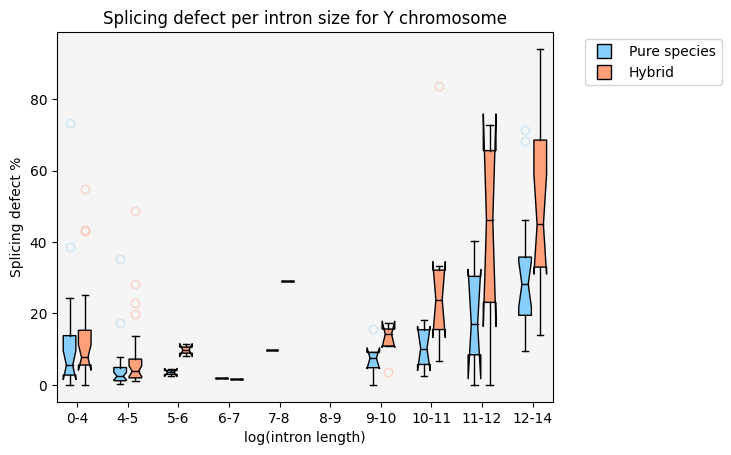

In [11]:
plt.boxplot(bins_yX, positions=range(1, len(pp)*2 - 2, 2), notch=True, patch_artist=True,
            boxprops=dict(facecolor="lightskyblue", color="k"),
            flierprops=dict(color="lightskyblue", markeredgecolor="lightskyblue",alpha=0.4),
            medianprops=dict(color="black"),);

plt.boxplot(bins_yY, positions=[x + 0.6 for x in range(1, len(pp)*2 - 2, 2)], notch=True,
            patch_artist=True,
            boxprops=dict(facecolor="lightsalmon", color="k"),
            flierprops=dict(color="lightsalmon", markeredgecolor="lightsalmon",alpha=0.4),
            medianprops=dict(color="black"),);

plt.ylabel("Splicing defect %")
plt.xlabel("log(intron length)")


handles, labels = plt.gca().get_legend_handles_labels()

point = [Line2D([0], [0], label='Pure species', marker='s', markersize=10, 
         markeredgecolor='k', markerfacecolor='lightskyblue', linestyle=''), 
        Line2D([0], [0], label='Hybrid', marker='s', markersize=10, 
         markeredgecolor='k', markerfacecolor='lightsalmon', linestyle='')]

handles.extend(point)

plt.xticks([x+0.3 for x in range(1, 20, 2)], labels=["0-4","4-5", "5-6", "6-7", "7-8", "8-9", "9-10", "10-11", "11-12", "12-14"]);
plt.gca().set_facecolor("whitesmoke")
plt.legend(handles=handles,bbox_to_anchor=(1.05, 1), loc='upper left')
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
plt.title("Splicing defect per intron size for Y chromosome")
plt.show();
# uncomment to save
#plt.savefig("<path to output file>.pdf", bbox_inches='tight')

In [14]:
x = "/lab/solexa_yamashita/people/Romain/Projets/Adrienne/AdrienneHybridConsolidated/omnisplice_run/Y_sim_mau_merge_omni.sd"

In [24]:
with open(x) as fi:
    fi.readline()
    fi.readline()
    fi.readline()
    for l in fi:
        
        spt = l.strip().split()
        ids = "_".join(spt[0:4])
        v = dico_h[ids]
        if v[0] != int(spt[6]):
            print(ids)
            print(spt)
            print(v)
            print()
                       

Y_scaffold1_169481_169549_+
['Y_scaffold1', '169481', '169549', '+', 'FBgn0046323', '0.91010636', '1711', '68', '101', 'FBtr0346720_exon_1']
[762, 32]

Y_scaffold1_169899_510568_+
['Y_scaffold1', '169899', '510568', '+', 'FBgn0046323', '0.06013363', '189', '354', '2600', 'FBtr0346720_exon_2']
[88, 169]

Y_scaffold1_511192_511245_+
['Y_scaffold1', '511192', '511245', '+', 'FBgn0046323', '0.6055527', '3468', '1168', '1091', 'FBtr0346720_exon_3']
[1388, 464]

Y_scaffold1_511562_694017_+
['Y_scaffold1', '511562', '694017', '+', 'FBgn0046323', '0.4512167', '1947', '1715', '653', 'FBtr0346720_exon_4']
[831, 694]

Y_scaffold1_694196_694479_+
['Y_scaffold1', '694196', '694479', '+', 'FBgn0046323', '0.8265023', '2682', '347', '216', 'FBtr0346720_exon_5']
[1139, 110]

Y_scaffold1_695123_695187_+
['Y_scaffold1', '695123', '695187', '+', 'FBgn0046323', '0.87413853', '2410', '153', '194', 'FBtr0346720_exon_6']
[998, 58]

Y_scaffold1_695326_1040381_+
['Y_scaffold1', '695326', '1040381', '+', 'FBgn00

In [15]:
dico_h

{'Y_scaffold1_1910965_1911022_+': [660, 10],
 'Y_scaffold1_1911691_2332206_+': [1376, 1044],
 'Y_scaffold1_2334056_2354940_+': [1161, 206],
 'Y_scaffold1_2355622_2355676_+': [1155, 85],
 'Y_scaffold1_2356061_2357875_+': [835, 341],
 'Y_scaffold1_2358319_2790802_+': [632, 554],
 'Y_scaffold1_2793982_2794047_+': [526, 18],
 'Y_scaffold1_2798129_2798191_+': [246, 73],
 'Y_scaffold1_2798296_2798349_+': [511, 68],
 'Y_scaffold1_2799292_2799352_+': [530, 16],
 'Y_scaffold1_2799846_2799908_+': [507, 37],
 'Y_scaffold1_169481_169549_+': [762, 32],
 'Y_scaffold1_169899_510568_+': [88, 169],
 'Y_scaffold1_511192_511245_+': [1388, 464],
 'Y_scaffold1_511562_694017_+': [831, 694],
 'Y_scaffold1_694196_694479_+': [1139, 110],
 'Y_scaffold1_695123_695187_+': [998, 58],
 'Y_scaffold1_695326_1040381_+': [296, 365],
 'Y_scaffold4_1325599_807891_-': [49, 178],
 'Y_scaffold4_1647080_1325934_-': [466, 97],
 'Y_scaffold4_2038134_1647657_-': [290, 38],
 'Y_scaffold4_2337295_2038313_-': [105, 74],
 'Y_scaffo

In [ ]:
sorted(yY, reverse=True)

In [57]:
dico_p['Y_scaffold1_2334056_2354940_+']

[829, 203]

In [53]:
dico_h

{'Y_scaffold1_1910965_1911022_+': [660, 105],
 'Y_scaffold1_1911691_2332206_+': [1376, 1159],
 'Y_scaffold1_2334056_2354940_+': [1161, 454],
 'Y_scaffold1_2355622_2355676_+': [1155, 165],
 'Y_scaffold1_2356061_2357875_+': [835, 625],
 'Y_scaffold1_2358319_2790802_+': [632, 593],
 'Y_scaffold1_2793982_2794047_+': [526, 43],
 'Y_scaffold1_2798129_2798191_+': [246, 123],
 'Y_scaffold1_2798296_2798349_+': [511, 150],
 'Y_scaffold1_2799292_2799352_+': [530, 59],
 'Y_scaffold1_2799846_2799908_+': [507, 81],
 'Y_scaffold1_169481_169549_+': [1711, 169],
 'Y_scaffold1_169899_510568_+': [189, 2954],
 'Y_scaffold1_511192_511245_+': [3468, 2259],
 'Y_scaffold1_511562_694017_+': [1947, 2368],
 'Y_scaffold1_694196_694479_+': [2682, 563],
 'Y_scaffold1_695123_695187_+': [2410, 347],
 'Y_scaffold1_695326_1040381_+': [699, 1054],
 'Y_scaffold4_1325599_807891_-': [64, 239],
 'Y_scaffold4_1647080_1325934_-': [610, 192],
 'Y_scaffold4_2038134_1647657_-': [361, 245],
 'Y_scaffold4_2337295_2038313_-': [144,

In [25]:
f = "/lab/solexa_yamashita/people/Romain/Projets/Adrienne/PAPER/checking/omni_Y_mau_onlyY/trimmed_sim_mau_3_S15_L002_VS_Mau.table"
cpt = 0
with open(f) as fi:
    fi.readline()
    for l in fi:
        cpt += 1
print(cpt)

212
